In [1]:

import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4096268.datarmor0/parcels-502090/libparcels_random_639612f4-a5c6-407d-ba10-19b4b39bf876.so


In [2]:
from dask.distributed import Client, LocalCluster

if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=3)
else:    
    cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.74:36651 Dashboard: http://10.148.0.74:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [4]:
t_start = df.index.min().compute()
t_end = df.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


In [5]:
df = pa.degs2ms(df)


In [6]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [7]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [8]:
df['velocity_amplitude'] = np.sqrt(df.zonal_velocity**2+df.meridional_velocity**2)

In [9]:
df = df.persist()

In [10]:
def add_geodata(df):

    df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)

    def build_polygon(r):
        lon0, lon1 = r.name[0].left, r.name[0].right
        lat0, lat1 = r.name[1].left, r.name[1].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(build_polygon, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    df['area'] = df.to_crs(crs = 'epsg:3857').area /1e6 / 1e4 # 100km^2 units
    
    return df

In [11]:
def mean_std_func(df):
    
    return df.agg(['mean'])

In [12]:
df.groupby([df.lon_cut, df.lat_cut]).apply(mean_std_func).compute()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


,,,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,velocity_amplitude
lon_cut,lat_cut,,,,,,,,,,,
"(-179.0, -178.0]","(32.0, 33.0]",mean,2.934969e+07,32.519894,-178.512360,0.0,0.156770,0.005061,0.764929,21.642828,34.486767,0.282190
"(-178.0, -177.0]","(0.0, 1.0]",mean,3.475740e+07,0.410251,-177.495118,0.0,-0.198716,-0.054815,0.821333,27.167955,35.205074,0.330976
"(-175.0, -174.0]","(68.0, 69.0]",mean,3.900035e+07,68.370154,-174.500457,0.0,-0.009185,0.016499,-2.028047,-1.537529,30.472075,0.057443
"(-174.0, -173.0]","(5.0, 6.0]",mean,3.507921e+07,5.465886,-173.502295,0.0,-0.025256,0.025919,0.810351,27.717535,34.769154,0.231930
"(-172.0, -171.0]","(5.0, 6.0]",mean,3.522788e+07,5.489051,-171.490556,0.0,-0.034284,0.016859,0.805496,27.714298,34.762482,0.220245
...,...,...,...,...,...,...,...,...,...,...,...,...
"(148.0, 149.0]","(20.0, 21.0]",mean,2.736972e+07,20.477933,148.490813,0.0,0.026125,0.039394,1.119506,27.780716,34.317654,0.321914
"(150.0, 151.0]","(51.0, 52.0]",mean,2.813704e+07,51.512366,150.527337,0.0,0.013961,-0.014327,0.130382,6.028405,32.285843,0.145723
"(156.0, 157.0]","(-46.0, -45.0]",mean,2.205527e+07,-45.491836,156.465597,0.0,0.043875,-0.013267,0.375122,11.800048,34.910789,0.199002


### Simple version (less workers needeed)

In [13]:
means = (df
         .groupby([df.lon_cut, df.lat_cut])
         .mean()
         .compute()
         #.to_frame()
        )



means = add_geodata(means)
#count['density'] = count['count']/count['area']

ds_mean = (means
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [24]:
std = (df
         .groupby([df.lon_cut, df.lat_cut])
         .std()
         .compute()
         #.to_frame()
        )



std = add_geodata(std)

ds_std = (std
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [25]:
ds_mean = ds_mean.rename({k :k+'_mean' for k in ds_mean.keys() })
ds_std = ds_std.rename({k :k+'_std' for k in ds_std.keys() })
ds = xr.merge([ds_mean,ds_std])

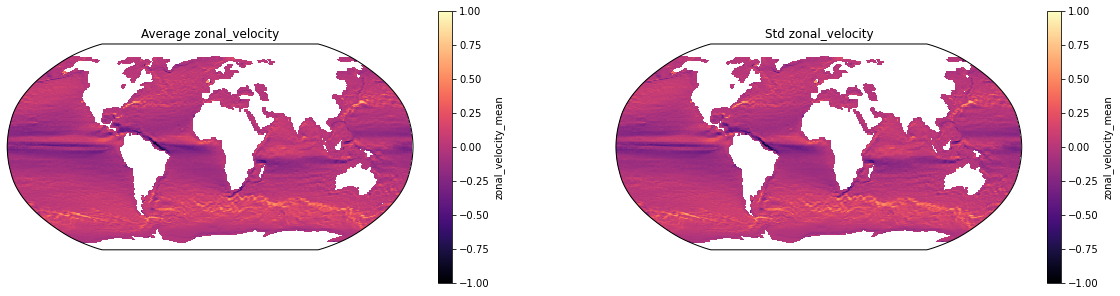

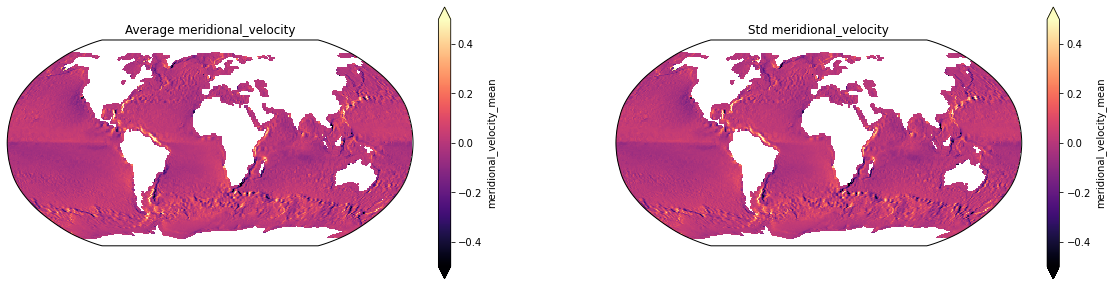

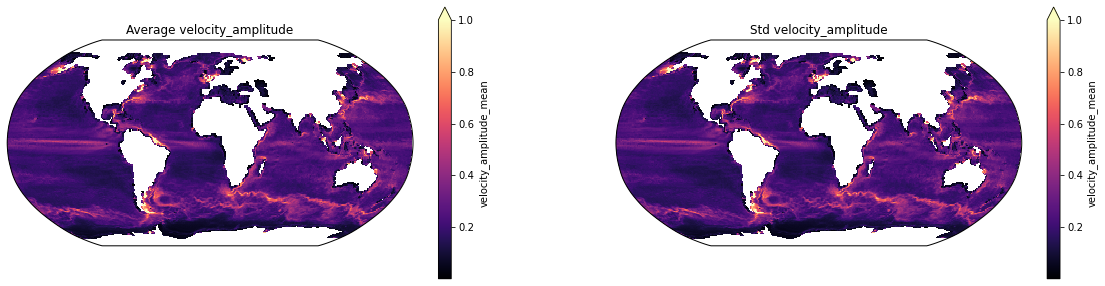

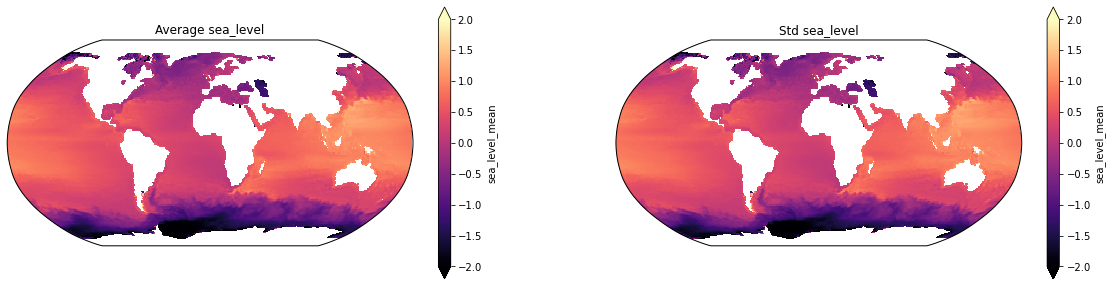

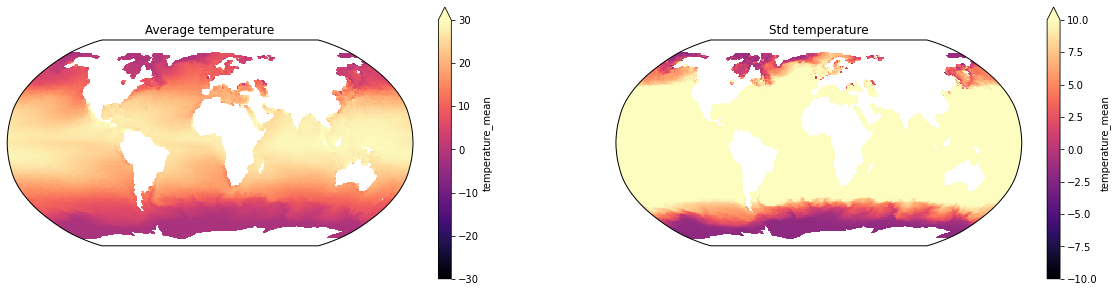

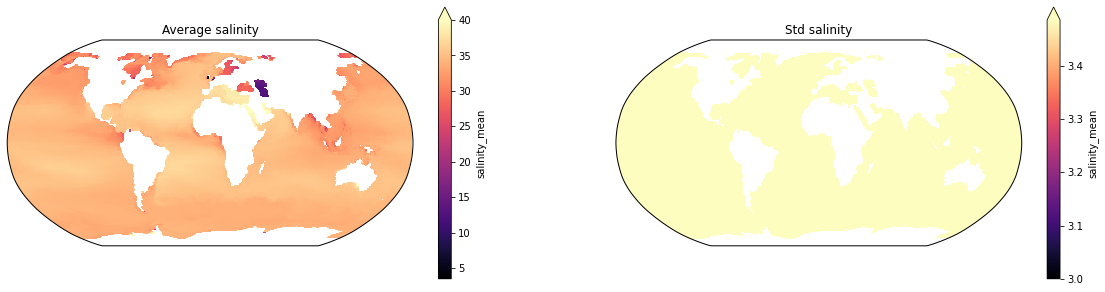

In [29]:
for V,vmax in zip(['zonal_velocity', 'meridional_velocity','velocity_amplitude','sea_level','temperature','salinity'],[[1,1],[0.5,0.5],[1,1],[2,2],[30,10],[40,3]]):
    figsize = (20,5)

    #crs = ccrs.Mollweide()
    crs = ccrs.Robinson()
    #crs = ccrs.EqualEarth()
    #crs = ccrs.Geodetic()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection=crs)

    ds[V+'_mean'].plot(x='lon', 
                     y='lat',
                     vmax=vmax[0],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Average '+V)
    ax = fig.add_subplot(122, projection=crs)

    ds[V+'_mean'].plot(x='lon', 
                     y='lat',
                     vmax=vmax[1],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Std '+V)
    #ax.add_feature(cfeature.LAND, zorder=1)



In [30]:
ds = ds.drop(['z_mean','z_std','trajectory_mean','trajectory_std'])

In [31]:
ds

<xarray.Dataset>
Dimensions:                   (lat: 179, lon: 359)
Coordinates:
  * lon                       (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
  * lat                       (lat) float64 -89.5 -88.5 -87.5 ... 86.5 87.5 88.5
Data variables:
    zonal_velocity_mean       (lon, lat) float64 nan nan nan nan ... nan nan nan
    meridional_velocity_mean  (lon, lat) float64 nan nan nan nan ... nan nan nan
    sea_level_mean            (lon, lat) float64 nan nan nan nan ... nan nan nan
    temperature_mean          (lon, lat) float64 nan nan nan nan ... nan nan nan
    salinity_mean             (lon, lat) float64 nan nan nan nan ... nan nan nan
    velocity_amplitude_mean   (lon, lat) float64 nan nan nan nan ... nan nan nan
    area_mean                 (lon, lat) float64 nan 49.22 28.8 ... 28.8 49.22
    zonal_velocity_std        (lon, lat) float64 nan nan nan nan ... nan nan nan
    meridional_velocity_std   (lon, lat) float64 nan nan nan nan ... nan nan nan
    sea_level_std             (lon, lat) float64 nan nan nan nan ... nan nan nan
    temperature_std           (lon, lat) float64 nan nan nan nan ... nan nan nan
    salinity_std              (lon, lat) float64 nan nan nan nan ... nan nan nan
    velocity_amplitude_std    (lon, lat) float64 nan nan nan nan ... nan nan nan
    area_std                  (lon, lat) float64 nan 49.22 28.8 ... 28.8 49.22

In [33]:
p.store_diagnostic("L_mean_std", ds,overwrite=True)

L_mean_std diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/L_mean_std.zarr


In [34]:
diags = p.load_diagnostic('L_mean_std.zarr')

In [35]:
diags

<xarray.Dataset>
Dimensions:                   (lat: 179, lon: 359)
Coordinates:
  * lat                       (lat) float64 -89.5 -88.5 -87.5 ... 86.5 87.5 88.5
  * lon                       (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    area_mean                 (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    area_std                  (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    meridional_velocity_mean  (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    meridional_velocity_std   (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    salinity_mean             (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    salinity_std              (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    sea_level_mean            (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    sea_level_std             (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    temperature_mean          (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    temperature_std           (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    velocity_amplitude_mean   (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    velocity_amplitude_std    (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    zonal_velocity_mean       (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    zonal_velocity_std        (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>

In [36]:
cluster.close()